# Semantic Segmentation with Vision Transformer

## Introduction

Semantic segmentation consists of classifying each pixel in an image into the corresponding class. The output of a semantic segmentation algorithm is a map with the same spatial dimensions as the input image, where each element of the map is an integer value from 0 to the number of classes. The image below shows an example of a semantic segmentation map taken from the KITTI Dataset. Note that each class has been color-coded.

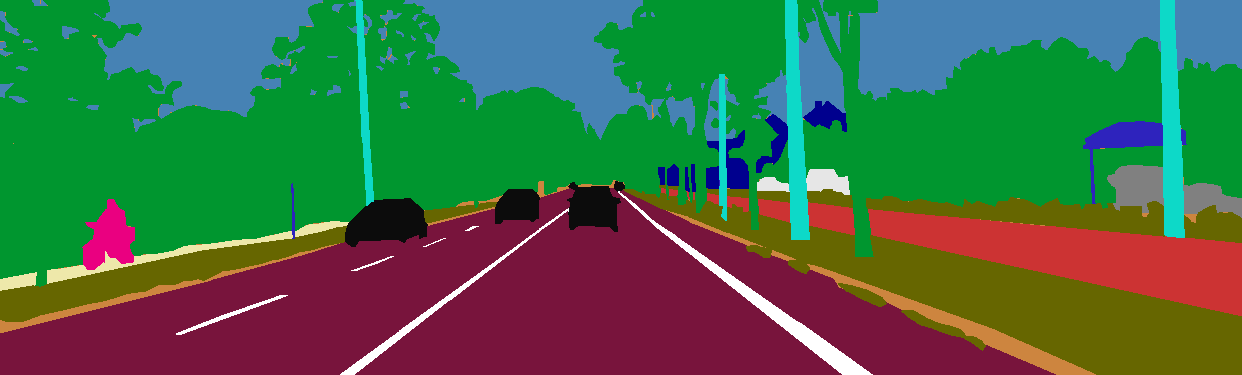

In this laboratory, you will learn how to build a Vision Transformer for semantic segmentation. The tutorial will focus, in particular, on how to create the model. It will divided into parts. The first one will focus on the creation of the dataset and the use of the Albumentation library (Buslaev, A.; Iglovikov, V.I.; Khvedchenya, E.; Parinov, A.; Druzhinin, M.; Kalinin, A.A. Albumentations: Fast and Flexible Image Augmentations. Information 2020, 11, 125. https://doi.org/10.3390/info11020125), which is a library dedicated to data augmentation in the task of segmentation and object detection. Then, there will be the creation of the Vision Transformer in each of its components. Finally, the training and testing of the model.

## Imports

In [ ]:
!pip install -Uqq ipdb
!pip install torchmetrics
!pip install albumentations

import ipdb

import math
import numpy as np
import pandas as pd
import os
from os.path import join
import glob
from sklearn.model_selection import StratifiedShuffleSplit
from PIL import Image
import random
from tqdm import tqdm
import cv2


from collections import Counter, OrderedDict
import matplotlib.pyplot as plt

import torch
from torch import nn

from torchsummary import summary
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as T

from torchmetrics import Accuracy, JaccardIndex
from torchmetrics import MetricCollection

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision.datasets import VOCSegmentation

torch.manual_seed(123)

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Dataset

The Pascal VOC dataset (http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) for semantic segmentation aims to recognize objects in realistic scenes. It provides the labeling of twenty object classes:

Person: person
Animal: bird, cat, cow, dog, horse, sheep
Vehicle: airplane, bicycle, boat, bus, car, motorbike, train
Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor

Moreover, it presents a background class and an "unlabeled pixels" class that in this tutorial will be merged together.

Download the dataset

In [ ]:
VOCSegmentation(root='./voc_dataset', image_set='trainval', transform=None, target_transform=None, download=True)


Dataset VOCSegmentation
    Number of datapoints: 2913
    Root location: ./voc_dataset

As mentioned before, the Albumentation library allows for the correct data augmentation of the inputs and the labels. Using the standard transformation without the proper attention could lead to the wrong transformation applied to the input and the target. For instance, in the following, you will be able to see what happens when a random rotation is applied in the standard way.

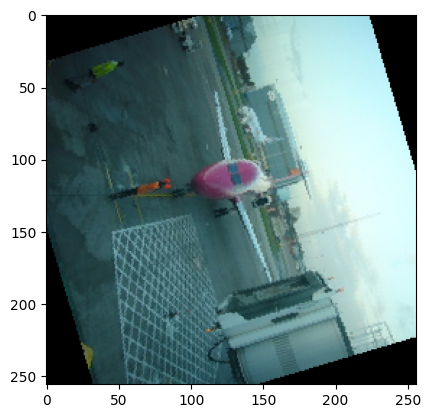

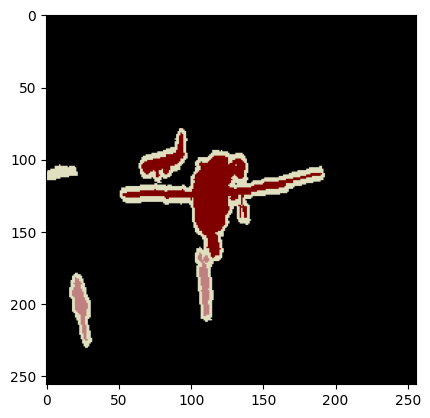

In [ ]:
# define transform
transforms = T.Compose([T.Resize((256, 256)),
                        T.RandomRotation(180)])

# initialize the dataset
dataset = VOCSegmentation(root='./voc_dataset', image_set='trainval', transform=transforms, target_transform=transforms, download=False)

# extract one couple of image and mask
image, mask = dataset.__getitem__(0)

plt.imshow(image)
plt.figure()
plt.imshow(mask, vmin=0., vmax=20.)
plt.show()

Overwrite the Dataset class to apply data augmentation using Albumentation library.

Albumentation can be used for semantic segmentation similarly to the standard pytorch procedures but specifying what is the image and what is the mask. The library will handle the transformations for both the image and the mask. The documentation and examples can be found at https://albumentations.ai/docs/getting_started/mask_augmentation/.

In [ ]:
class VOCSegmentation_Albumentation(VOCSegmentation):

    def __init__(self, root, image_set='trainval', transform=None, download=False):
        super().__init__(root=root, image_set=image_set, transform=None, target_transform=None, download=download)

        self.transform = transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        img, mask = super().__getitem__(idx)

        img = np.array(img)
        mask = np.array(mask)
        mask[mask==255] = 0 # for this exercise the unlabeled pixels will be considered as background

        ######################
        # YOUR CODE HERE

        # Apply transformations with albumentation

        
        return img.float(), mask.long()

Test dataset class

torch.Size([3, 256, 256])
torch.Size([256, 256])
tensor([ 0,  1, 15])


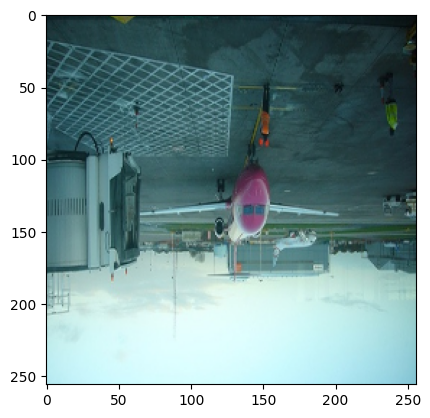

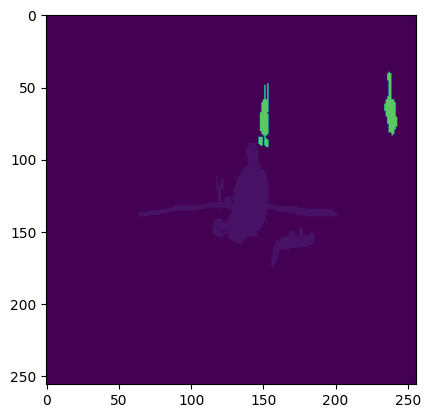

In [ ]:

root_dir = './voc_dataset'

# define transform
transforms = A.Compose([A.Resize(height=256, width=256),
                       A.RandomRotate90(),
                       A.Transpose(),
                       ToTensorV2()])


dataset = VOCSegmentation_Albumentation(root=root_dir, image_set='train', transform=transforms)

image, mask = dataset.__getitem__(0)

print(image.shape)
print(mask.shape)
print(mask.unique())

plt.imshow(image.permute(1,2,0).detach().to('cpu').numpy().astype(int))
plt.figure()
plt.imshow(mask.detach().to('cpu').numpy(), vmin=0., vmax=20.)
plt.show()


# Vision Transformer

Starting with semantic segmentation, a neural network for this task is typically composed of two parts: an Encoder and a Decoder. The Encoder extracts features from the input and corresponds to the backbone of the network. The Decoder takes the features extracted and reconstructs a map of the same dimension of the original image where each pixel corresponds to a class.

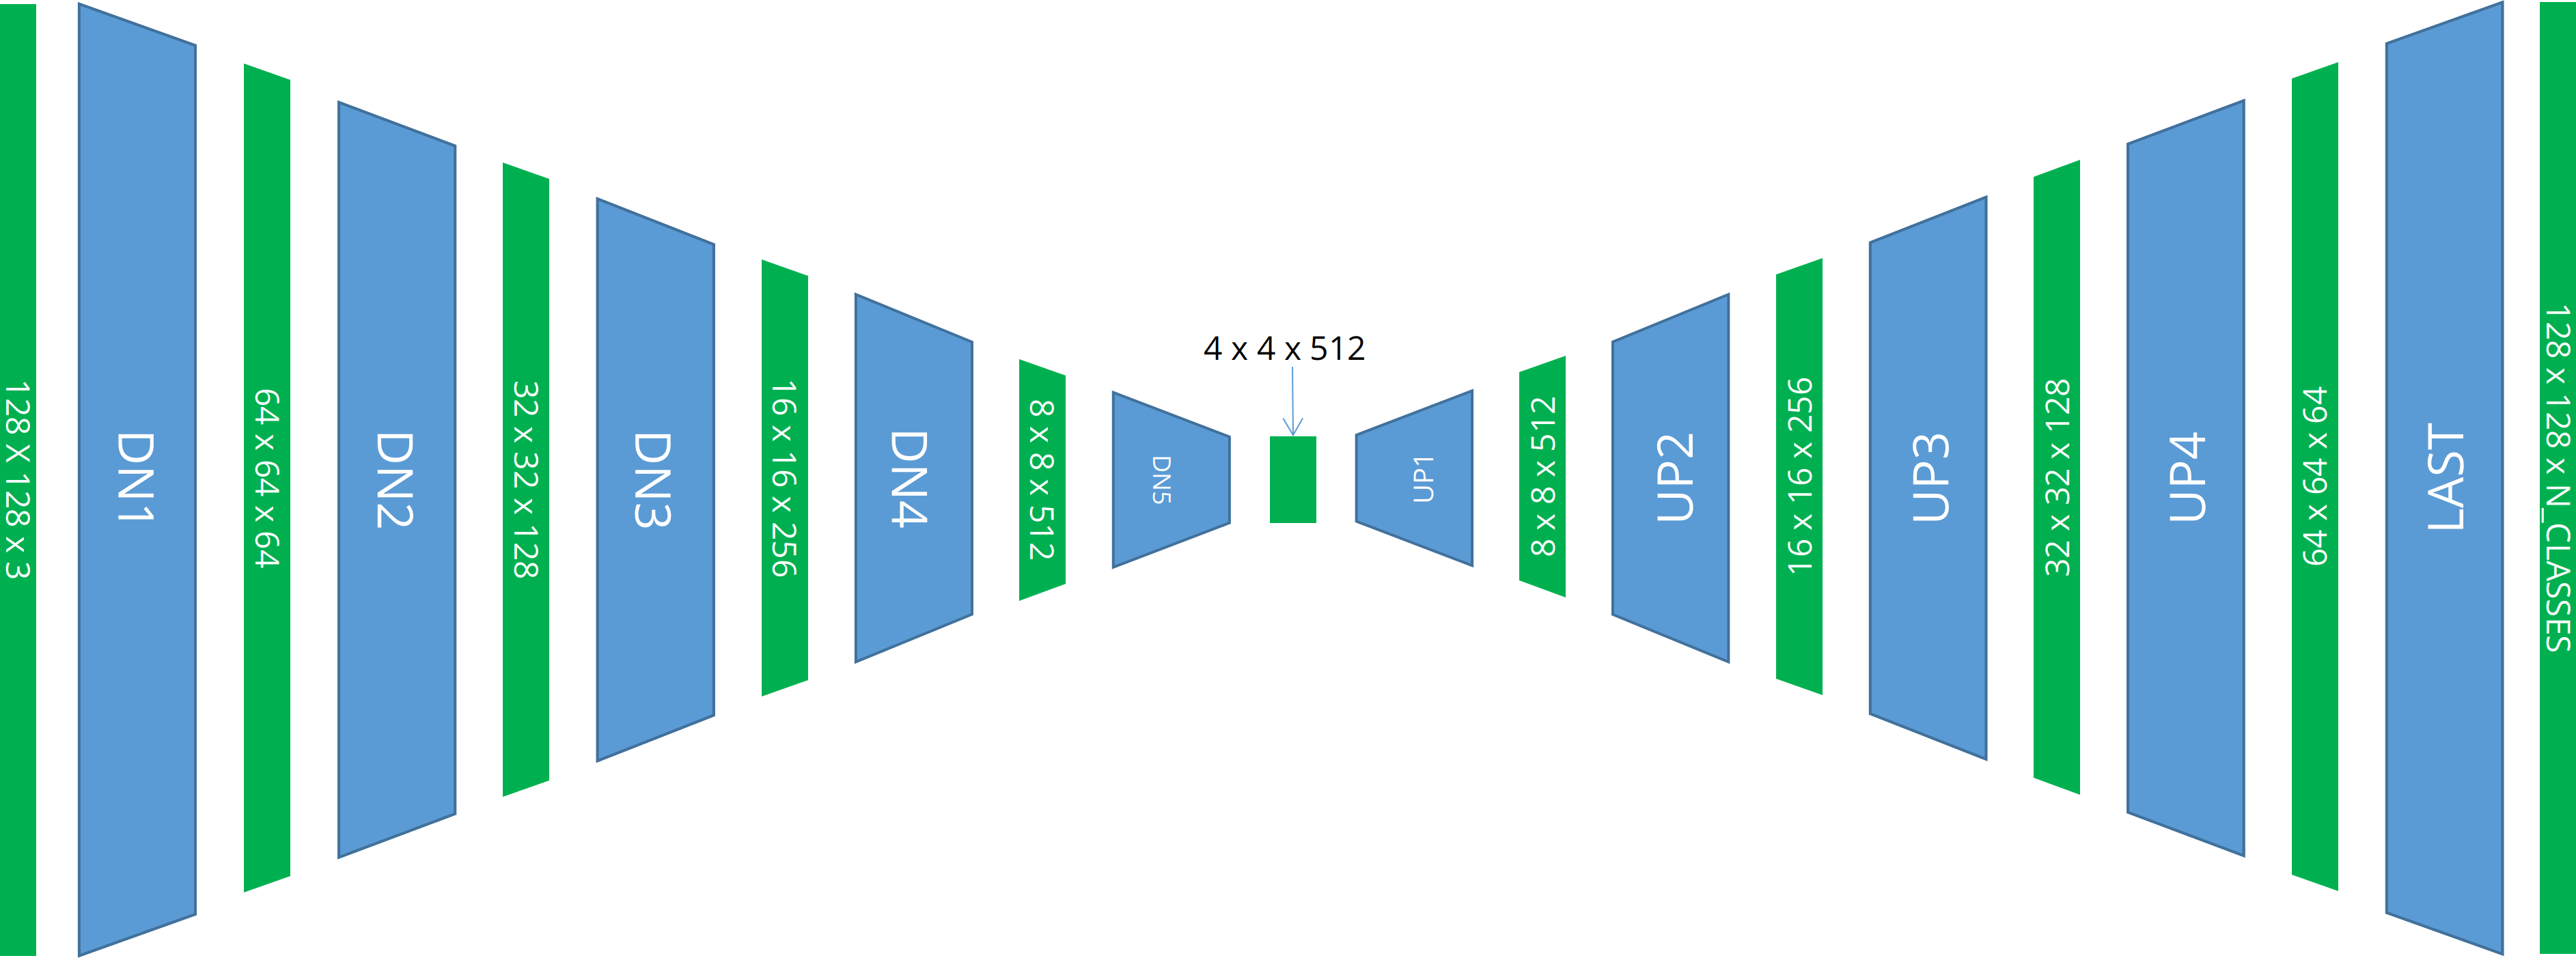

Example of architecture for segmentation from https://github.com/M2Lschool/tutorials2022/blob/main/1_vision/ComputerVisionPart2.ipynb.

The idea in this tutorial is to use the Vision Transformer (ViT) as the backbone of the network. Vision Transformer is the first Transformer used for computer vision tasks. ViT is similar to the original Transformer for NLP. The idea behind ViT is to use patches of the image as tokens, substituting the words of the sentences that represent the tokens in the classical NLP transformer. ViT was originally created for the task of classification, but in this tutorial, it will be modified by adding a Decoder Head to it for the extraction of semantic segmentation maps.

The code is composed of 5 different modules:


1.  PatchEmbedding: it handles the embedding of the patches of the image;
2.  Attention: the first component of the Transformer Block, it processes the self-attention between the tokens;
3.  MLP: multi perceptron/feed forward layer of the Transformer Block;
4.  Block: it is the Transformer Block that includes the Attention and the MLP module;
5.  DecoderHead: it is the decoder of the segmentation model;
6.  VisionTransformer: it is composed of all the other modules, also handling the positional encoding.


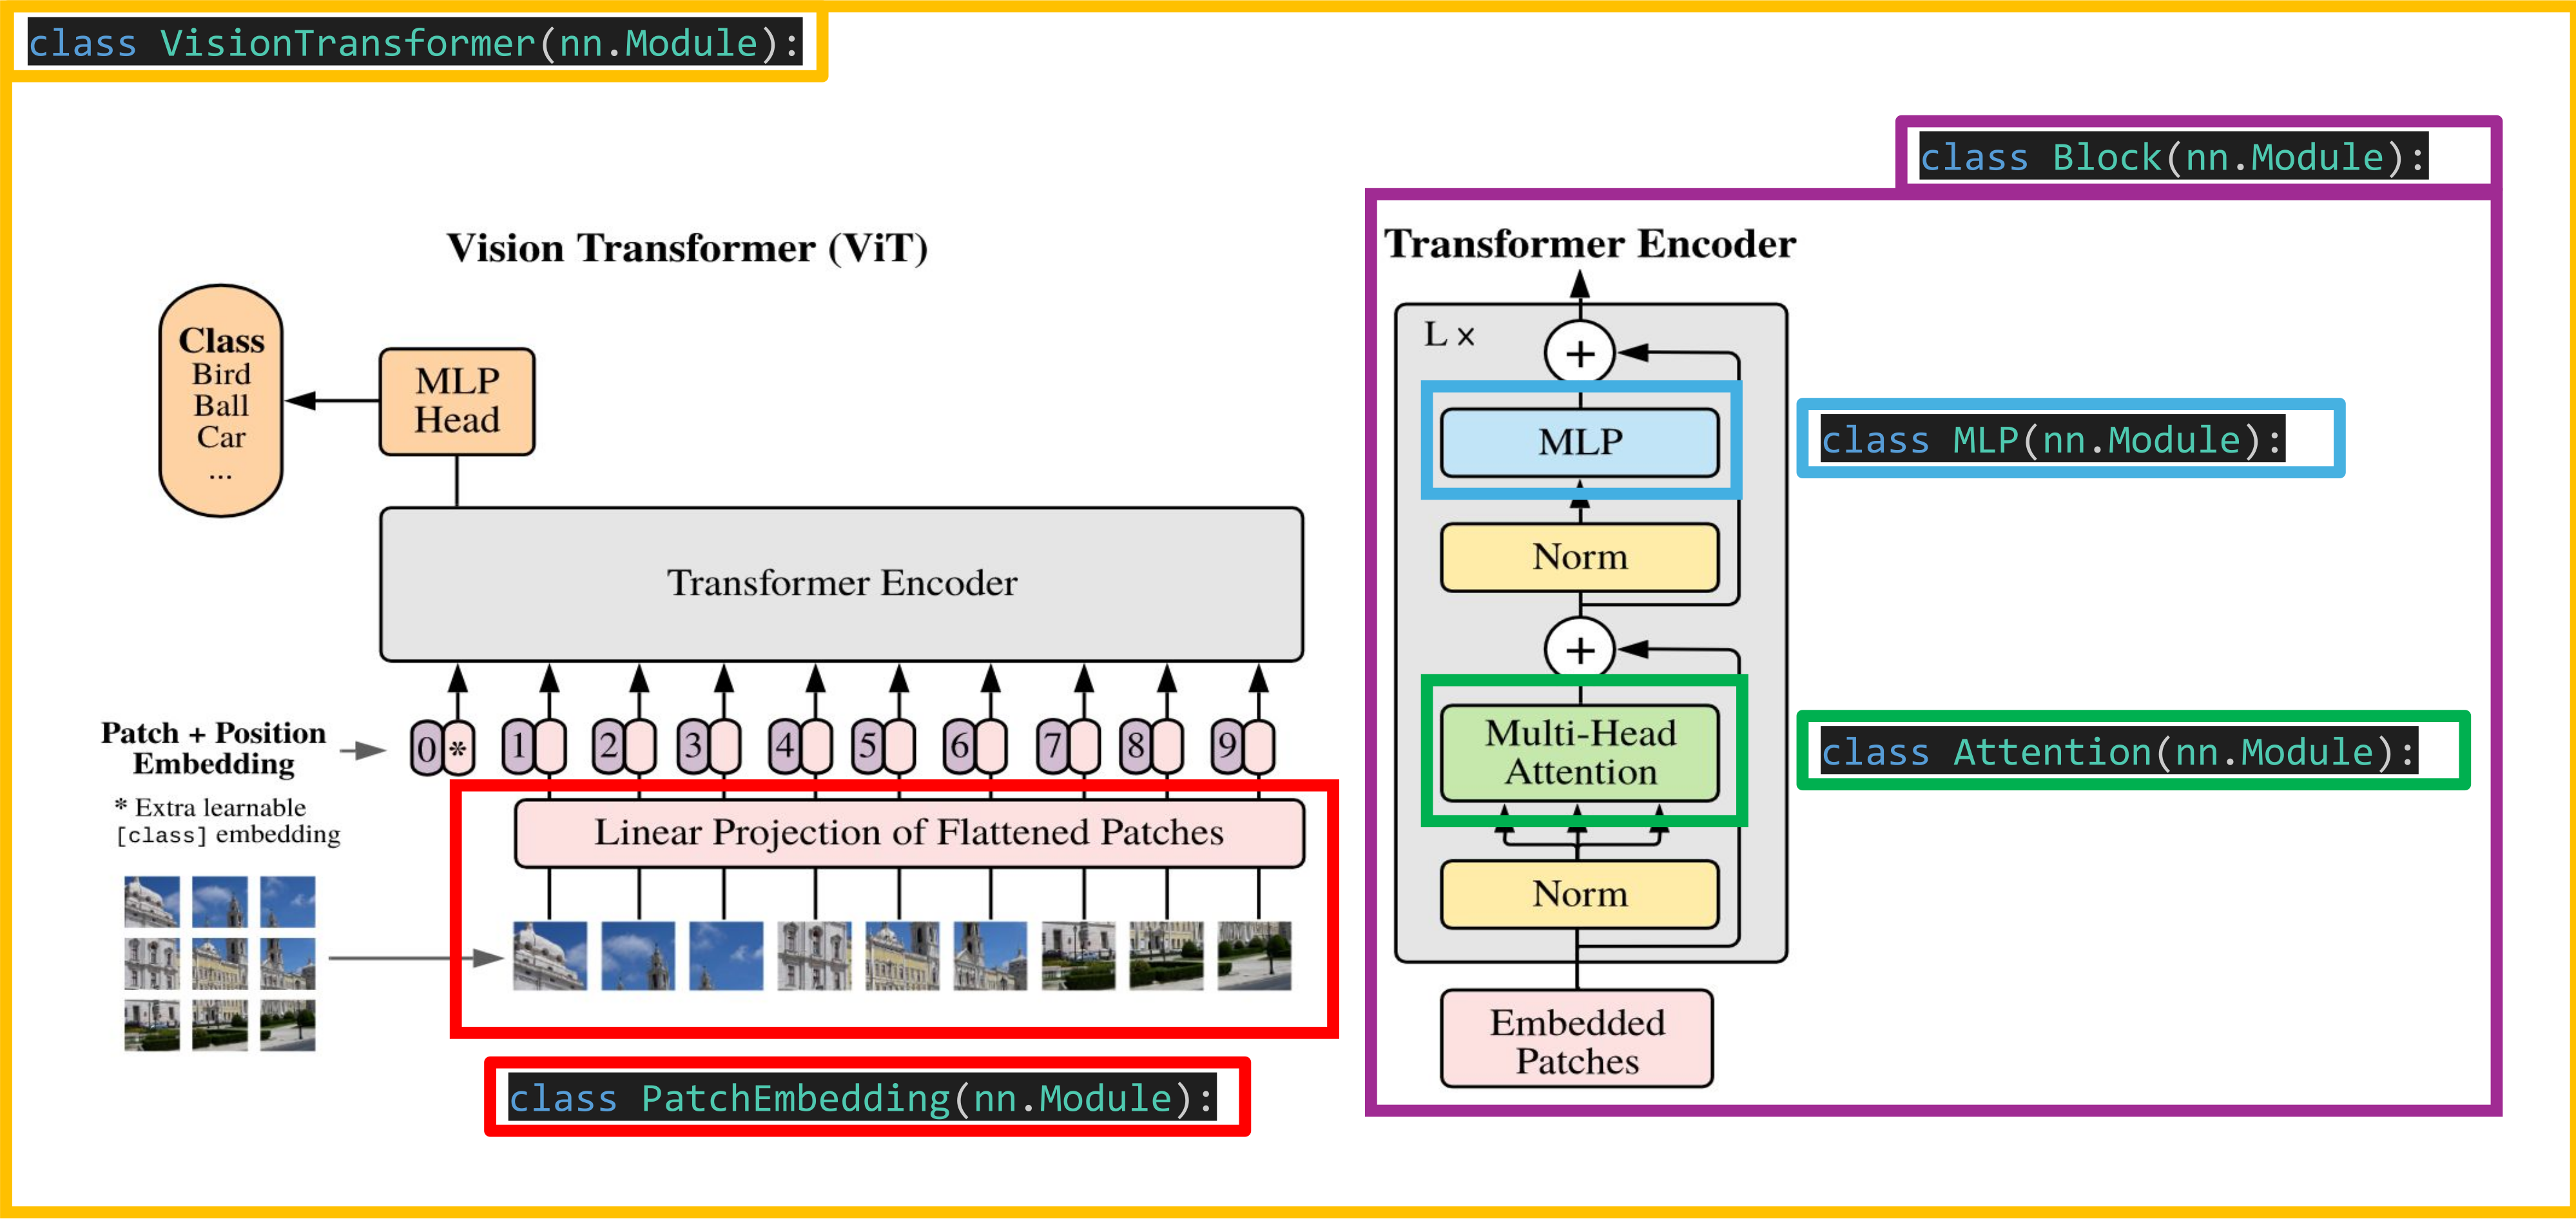


## Patch Embedding

The patch embedding of non-overlapping patches is achieved using 2d convolution with kernel size and stride equal to the patch size

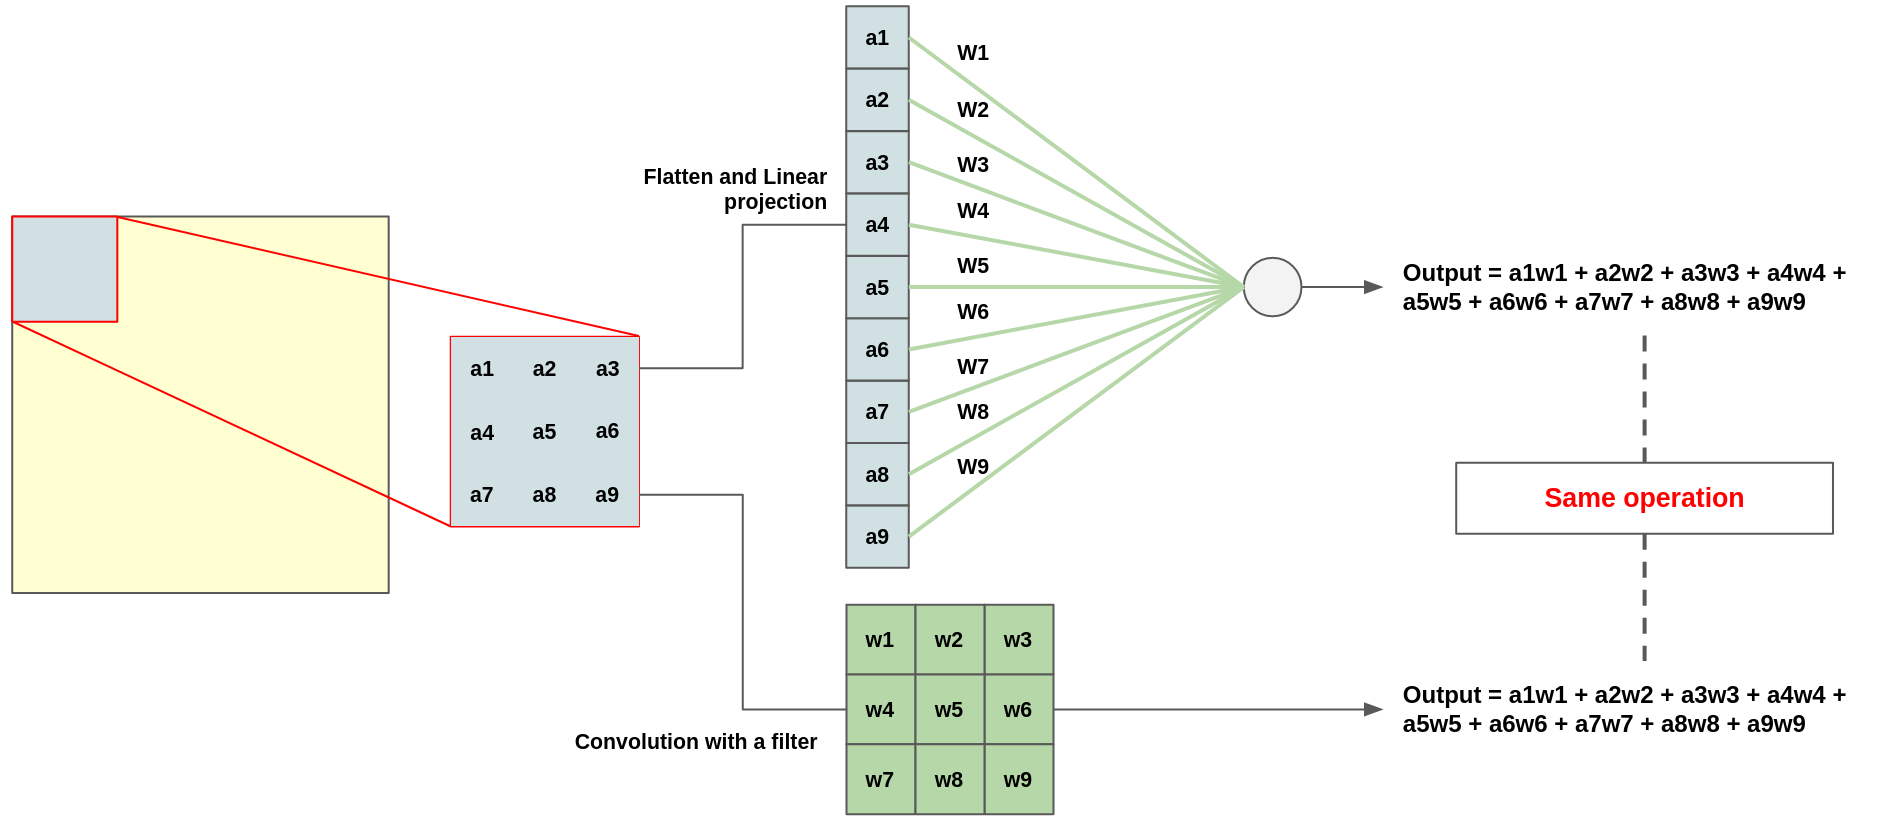

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, im_size, patch_size, in_channels=3, dim_emb=768):
      super().__init__()
      ######################
      # YOUR CODE HERE

      # Create the embedding using Conv2d instead of linear projection (same operation)


    def forward(self, x):
      ######################
      # YOUR CODE HERE

      # Compute the the embedding, the final shape has to be (batch_size, num_patches, dim_emb)

      return x

### Patch embedding test

In [ ]:
im_size = 224
patch_size = 16
in_channels = 3
batch_size = 4
dim_emb = 768

test_embedding = PatchEmbedding(im_size, patch_size, in_channels, dim_emb)
batch_sample = torch.rand(batch_size,in_channels,im_size,im_size) # batch of 4 images
batch_embedding = test_embedding(batch_sample)

batch_embedding.shape # expected output --> torch.Size([4, 196, 768])

torch.Size([4, 196, 768])

## Multi-Head Attention

It computes the Multi-Head Attetion between tokens using this formula:

$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d}})V$

In [ ]:
class Attention(nn.Module):
    """
    Inputs
        dim: embedding dimension per features token
        n_heads: number of attention head
        qkv_bias: bool
        attn_p: Probability Dropout on qkv
        proj_p: Probability Dropout on output tensor

    Attributes:
        scale: normalize the dot product
        qkv: linear_projection
        proj: linear layer for the concatenated output of the attention module
        attn_drop: nn.Dropout
    """

    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim*3, bias=qkv_bias) # dim*3 because query, key and value are projected together and then splitted
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        """
        x.shape = (n_samples, n_patches, dim)
        """

        n_samples, n_tokens, dim = x.shape

        if dim != self.dim: # sanity check
            raise ValueError


        ######################
        # YOUR CODE HERE
        
        # create q, k, and v
        # qkv --> [n_samples, n_patches, dim*3]
        
        # divide query key and value for each token for each head --> [n_samples, n_patches, 3, n_heads, head_dim], the idea is similar to qkv that are compute together aand then split
 
        # divide q, k and v in differnt variables

        # Compute self-attention between q, the transpose of k, and v
        # Attention = Softmax( ( Q @ K.T) / scale) @ V with @ = dot product
        # Softmax is on the last dimension

        attn = self.attn_drop(attn) # apply the dropout on the attention matrix obtained after Softmax( ( Q @ K.T) / scale)

        ######################
        # YOUR CODE HERE
        
        # Compute the final steps for the attention mechanism
        # shape of the result [n_samples, n_heads, n_patches, head_dim]

        # concatenate heads
        weighted_avg = weighted_avg.transpose(1,2) # (n_samples, n_patches, n_head, head_dim)
        weighted_avg = weighted_avg.flatten(2) # (n_samples, n_patches, dim)

        # project heads
        x = self.proj(weighted_avg)
        x = self.proj_drop(x)

        return x

### Test Attention Module

In [ ]:
im_size = 224
patch_size = 16
in_channels = 3
batch_size = 4
dim_emb = 768
n_heads = 12

test_embedding = PatchEmbedding(im_size, patch_size, in_channels, dim_emb)
test_attention = Attention(dim_emb, n_heads)

batch_sample = torch.rand(batch_size,in_channels,im_size,im_size) # batch of 4 images
batch_embedding = test_embedding(batch_sample)
batch_attention = test_attention(batch_embedding)

batch_attention.shape # expected output --> torch.Size([4, 196, 768])

torch.Size([4, 196, 768])

## MLP

The Multi Layer Perceptron consists of:

1.  Linear layer from in_features to hidden_features
2.  Activation function (in this case we will use GELU)
3.  Linear layer from hidden_features to out_features
4.  Dropout

The in_features and out_features in the case of ViT correspond to the dimensional embedding of the tokens and are always the same for all of the architecture

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, proj_p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(proj_p)

    def forward(self, x):
        """
        x.shape() = (n_samples, n_patches, in_features)
        """

        x = self.fc1(x) # (n_samples, n_patches, hidden_features)
        x = self.act(x) # (n_samples, n_patches, hidden_features)
        x = self.drop(x) # (n_samples, n_patches, hidden_features)
        x = self.fc2(x) # (n_samples, n_patches, hidden_features)
        x = self.drop(x) # (n_samples, n_patches, hidden_features)

        return x

## Transformer Block

As shown in the ViT architecture image, the Transformer Block consists of:

1.  A normalization layer
2.  An attention layer
3.  Another normalization layer
4.  An MLP

In [ ]:
class Block(nn.Module):

    def __init__(self, dim, n_heads=12, mlp_ratio=4.0, qkv_bias=True, proj_p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-06)
        self.attn = Attention(dim, n_heads=n_heads, qkv_bias=qkv_bias, attn_p=attn_p, proj_p=proj_p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-06)

        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim,
                       hidden_features=hidden_features,
                       out_features=dim,
                       proj_p=proj_p)


    def forward(self, x):
        ######################
        # YOUR CODE HERE

        # Execute the operations in the correct order

        return x

## Decoder head

It takes in input the tokens from the final transformer block, reshapes them to the shape of an image, and then applies a series of Upsample and Convolution till the original dimension of the image is reached. The last layer classifies each pixel of the image.

In [ ]:
class Upsampler(nn.Module):
    def __init__(self, dim_emb):
        super(Upsampler, self).__init__()

        self.upsampler = nn.Sequential(nn.Upsample(scale_factor=2, mode='bicubic'),
                                       nn.Conv2d(in_channels=dim_emb, out_channels=dim_emb, kernel_size=3, padding=1),
                                       nn.GELU())

    def forward(self, x):
        return self.upsampler(x)


class DecoderHead(nn.Module):
    def __init__(self, num_tokens, dim_emb, patch_size, num_classes):
        super(DecoderHead, self).__init__()

        self.num_token_wh = np.sqrt(num_tokens).astype(int)
        self.patch_size = patch_size
        self.dim_emb = dim_emb

        # 256, 16 --> 16*16 --> Upsample with factor patch size
        scale_exponent = math.log2(patch_size)
        self.upsamplers = nn.ModuleList([Upsampler(dim_emb=dim_emb) for _ in np.arange(scale_exponent)])

        # self.upsample = nn.Upsample(scale_factor=patch_size, mode='bicubic')
        self.out = nn.Conv2d(in_channels=dim_emb, out_channels=num_classes, kernel_size=3, padding=1)


    def forward(self, tokens):
        ######################
        # YOUR CODE HERE

        # reshape from tokens to image shape (batch_size, dim_emb token_wh, token_wh)

        # Upsample + Conv till the original size is obtained
        # tokens = self.upsample(tokens)
        for up in self.upsamplers:
            tokens = up(tokens)

        out = self.out(tokens)

        return out


## Vision Transformer model

In [ ]:
class VisionTransformer(nn.Module):

    def __init__(self,
                 im_size=384,
                 patch_size=16,
                 in_channels=3,
                 n_classes=1000,
                 dim_emb=768,
                 depth=12,
                 n_heads=12,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 proj_p=0.,
                 attn_p=0.):

        super().__init__()

        assert dim_emb % n_heads == 0, 'dim_emb needs to be a multiple of n_heads'
        assert im_size % patch_size == 0, 'im_size needs to be a multiple of patch_size'
        assert math.log2(patch_size) - np.round(math.log2(patch_size)) == 0, 'for the purpose of this exercise and the DecoderHead, the pacth_size must be a power of 2'

        self.patch_embed = PatchEmbedding(im_size=im_size, patch_size=patch_size, in_channels=in_channels, dim_emb=dim_emb)

        n_patches = (im_size // patch_size) ** 2
        self.pos_emb = nn.Parameter(torch.zeros(1, n_patches, dim_emb)) # parameter of the network to learn the positional embedding
        self.pos_drop = nn.Dropout(p=proj_p)

        self.blocks = nn.ModuleList([Block(dim=dim_emb,
                                           n_heads=n_heads,
                                           mlp_ratio=mlp_ratio,
                                           qkv_bias=qkv_bias,
                                           proj_p=proj_p,
                                           attn_p=attn_p) for _ in range(depth)
                                     ])

        self.norm = nn.LayerNorm(dim_emb, eps=1e-06)
        self.decoder = DecoderHead(num_classes=n_classes, num_tokens=n_patches, dim_emb=dim_emb, patch_size=patch_size)


    def forward(self, x):
        x = self.patch_embed(x) # patch embeddings

        x = x + self.pos_emb # tokens creations
        x = self.pos_drop(x)

        # blocks executions
        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = self.decoder(x)

        return x

# Training and Testing the model

## Training loop

In [ ]:
def train(net, train_loader, val_loader, conf_train):

    device = conf_train['device']
    epochs = conf_train['epochs']
    loss_function = conf_train['loss_function'].to(device)
    train_metric_function = conf_train['metric_function'].to(device)
    val_metric_function = train_metric_function.clone()
    optimizer = conf_train['optimizer']

    net.to(device)

    # Needed Variables
    epochs_train_losses = []
    epochs_val_losses = []

    epochs_train_acc = []
    epochs_val_acc = []
    epochs_train_iou = []
    epochs_val_iou = []

    max_val_iou = 0

    with tqdm(range(epochs)) as progress:
      for epoch in progress:
        # train epoch
        batch_train_losses = []
        batch_val_losses = []

        net.train()
        for i, batch in enumerate(train_loader):
          im, gt = batch

          im = im.to(device)
          gt = gt.to(device)

          pred = net(im)

          # compute train loss
          loss = loss_function(pred, gt)

          # compute train accuracy
          train_metric_function.update(pred, gt)

          # backward
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          batch_train_losses.append(loss.detach().to('cpu'))

        epochs_train_losses.append(np.mean(batch_train_losses))
        train_metrics = train_metric_function.compute()
        epochs_train_acc.append(train_metrics['MulticlassAccuracy'].to('cpu').item())
        epochs_train_iou.append(train_metrics['MulticlassJaccardIndex'].to('cpu').item())
        train_metric_function.reset()

        net.eval()
        # Validation loop
        with torch.no_grad():
          for i, batch in enumerate(val_loader):
            im, gt = batch

            im = im.to(device)
            gt = gt.to(device)

            pred = net(im)

            # compute val loss
            loss = loss_function(pred, gt)
            batch_val_losses.append(loss.detach().to('cpu'))

            # compute validation metrics
            val_metric_function.update(pred, gt)

          epochs_val_losses.append(np.mean(batch_val_losses))
          val_metrics = val_metric_function.compute()
          epochs_val_acc.append(val_metrics['MulticlassAccuracy'].to('cpu').item())
          epochs_val_iou.append(val_metrics['MulticlassJaccardIndex'].to('cpu').item())
          val_metric_function.reset()

        progress.set_postfix({'train_loss': np.round(epochs_train_losses[-1],2),
                              'train_acc': np.round(epochs_train_acc[-1],2),
                              'train_iou': np.round(epochs_train_iou[-1],2),
                              'validation_loss': np.round(epochs_val_losses[-1],2),
                              'validation_acc': np.round(epochs_val_acc[-1],2),
                              'validation_iou': np.round(epochs_val_iou[-1],2)})

        if epochs_val_iou[-1] > max_val_iou:
          # save the model
          torch.save(net.state_dict(), 'best-model.pt')

          # sub max_val_metric
          max_val_iou = epochs_val_iou[-1]


    losses = {
              'train_losses' : epochs_train_losses,
              'val_losses': epochs_val_losses,
              }

    metrics = {
          'train_acc' : epochs_train_acc,
          'train_iou' : epochs_train_iou,
          'val_acc' : epochs_val_acc,
          'val_iou' : epochs_val_iou,}


    return net, losses, metrics


## Test loop

In [ ]:
def test(net, test_loader, conf_test):
  device = conf_test['device']
  metric_function = conf_test['metric_function'].to(device)

  net.to(device)

  net.eval()
  with torch.no_grad():
    for i, batch in enumerate(test_loader):
      im, gt = batch

      im = im.to(device)
      gt = gt.to(device)

      pred = net(im)

      # compute metrics
      metric_function.update(pred, gt)

    test_metrics = metric_function.compute()
    metric_function.reset()

  return test_metrics['MulticlassAccuracy'], test_metrics['MulticlassJaccardIndex']


## Set hyperparameters

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset parameters
root_path = './voc_dataset'

im_size=256
num_classes = 21

# Transformer parameters
patch_size = 16
in_channels = 3
dim_emb = 16
num_heads = 2
num_blocks = 3
dropout = 0.4

# Training parameter
epochs = 500
lr = 1e-4
batch_size = 50
num_workers = 2


## Creation and summary of the model

In [ ]:
model = VisionTransformer(im_size=im_size,
                          patch_size=patch_size,
                          in_channels=in_channels,
                          n_classes=num_classes,
                          dim_emb=dim_emb,
                          depth=num_blocks,
                          n_heads=num_heads,
                          mlp_ratio=2.,
                          qkv_bias=True,
                          proj_p=dropout,
                          attn_p=dropout)

summary(model.to(device), (in_channels, im_size, im_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]          12,304
    PatchEmbedding-2              [-1, 256, 16]               0
           Dropout-3              [-1, 256, 16]               0
         LayerNorm-4              [-1, 256, 16]              32
            Linear-5              [-1, 256, 48]             816
           Dropout-6          [-1, 2, 256, 256]               0
            Linear-7              [-1, 256, 16]             272
           Dropout-8              [-1, 256, 16]               0
         Attention-9              [-1, 256, 16]               0
        LayerNorm-10              [-1, 256, 16]              32
           Linear-11              [-1, 256, 32]             544
             GELU-12              [-1, 256, 32]               0
          Dropout-13              [-1, 256, 32]               0
           Linear-14              [-1, 

## Initialization of the dataset

In [ ]:
train_transforms = A.Compose([A.Resize(height=im_size+(im_size//2), width=im_size+(im_size//2)),
                              A.RandomCrop(height=im_size, width=im_size),
                              A.ColorJitter(),
                              A.Rotate(180),
                              A.HorizontalFlip(0.5),
                              A.VerticalFlip(0.5),
                              A.Normalize(),
                              ToTensorV2()])

val_transforms = A.Compose([A.Resize(height=im_size, width=im_size),
                            A.Normalize(),
                            ToTensorV2()])

train_set = VOCSegmentation_Albumentation(root=root_dir, image_set='train', transform=transforms)
test_set = VOCSegmentation_Albumentation(root=root_dir, image_set='val', transform=transforms)

val_set, test_set = torch.utils.data.random_split(test_set, [0.5, 0.5])

print(train_set.__len__())
print(val_set.__len__())
print(test_set.__len__())

train_loader = data.DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, drop_last=True, shuffle=True)
val_loader = data.DataLoader(dataset=val_set, num_workers=num_workers, batch_size=batch_size, drop_last=False, shuffle=False)
test_loader = data.DataLoader(dataset=test_set, num_workers=num_workers, batch_size=batch_size, drop_last=False, shuffle=False)

1464
725
724


## Loss function definition

In [ ]:
loss_function = nn.CrossEntropyLoss(ignore_index=0) # the background, labeled with 0, will be ignored

Evaluation metrics

In [ ]:
# Metric collection compute all the metrics required and output them in a dictionary

metric_function = MetricCollection([Accuracy(num_classes=num_classes, task='multiclass', average='macro', ignore_index=0),
                                    JaccardIndex(num_classes=num_classes, task='multiclass', average='macro', ignore_index=0)])  # the background, labeled with 0, will be ignored

## Optimizer definition

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-9)

## Training

In [ ]:
conf_train = {
              'epochs' : epochs,
              'loss_function' : loss_function,
              'optimizer' : optimizer,
              'metric_function' : metric_function,
              'device' : device,
              }

In [ ]:
new_model, losses, metrics = train(model, train_loader, val_loader, conf_train)

 16%|█▌        | 78/500 [15:07<1:21:42, 11.62s/it, train_loss=2.65, train_acc=0.07, train_iou=0.02, validation_loss=2.77, validation_acc=0.07, validation_iou=0.02]

In [ ]:
plt.plot(range(epochs), losses['train_losses'])
plt.title('Loss')

plt.plot(range(epochs), losses['val_losses'])
# plt.title('Validation Loss')
plt.show()

plt.plot(range(epochs), metrics['train_acc'])
plt.title('Accuracy')

plt.plot(range(epochs), metrics['val_acc'])
# plt.title('Validation Accuracy')
plt.show()

plt.plot(range(epochs), metrics['train_iou'])
plt.title('IOU')

plt.plot(range(epochs), metrics['val_iou'])
# plt.title('Validation Accuracy')
plt.show()

NameError: name 'losses' is not defined

## Test

In [ ]:
best_model = VisionTransformer(im_size=im_size,
                               patch_size=patch_size,
                               in_channels=in_channels,
                               n_classes=num_classes,
                               dim_emb=dim_emb,
                               depth=num_blocks,
                               n_heads=num_heads,
                               mlp_ratio=2.,
                               qkv_bias=True,
                               proj_p=dropout,
                               attn_p=dropout)
best_model.load_state_dict(torch.load('best-model.pt'))

test_accuracy, test_iou = test(best_model, test_loader, conf_train)
print('The overall accuracy on the test set is: ' + str(test_accuracy))
print('The overall IoU on the test set is: ' + str(test_iou))

The overall accuracy on the test set is: tensor(0.1167, device='cuda:0')
The overall IoU on the test set is: tensor(0.0514, device='cuda:0')


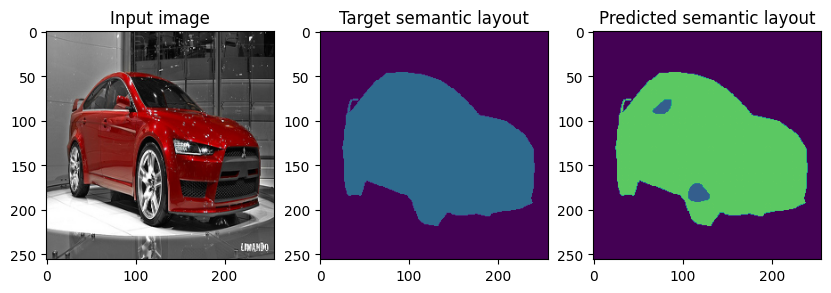

In [ ]:
plot_test_set = test_set
plot_test_set.dataset.transform = A.Compose([A.Resize(height=im_size, width=im_size),
                                             ToTensorV2()])

image, mask = test_set.__getitem__(0)
plot_image, plot_mask = plot_test_set.__getitem__(0) # the RGB image is not normalized

image = image.to(device)
mask = mask.to(device)

pred = best_model(image.unsqueeze(dim=0))
pred = pred.argmax(dim=1)

pred = pred.squeeze()
pred[plot_mask == 0] = 0 # remove background

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title('Input image')
plt.imshow(plot_image.permute(1,2,0).detach().to('cpu').numpy().astype(int))
plt.subplot(1, 3, 2)
plt.title('Target semantic layout')
plt.imshow(plot_mask.detach().to('cpu').numpy(), vmin=0., vmax=20.)
plt.subplot(1, 3, 3)
plt.title('Predicted semantic layout')
plt.imshow(pred.detach().to('cpu').numpy(), vmin=0., vmax=20.)
plt.show()